# Module 8 Discussion

This notebook explores the U.S. highway fatalities dataset collected from the Bureau of Transportation Statistics (BTS) [4]. The dataset tracks the quarterly count of the number of U.S. highway fatalities from 2008 - 2020. It also includes the rate of highway fatalities for every million miles driven.  
  
In this notebook, I do some exploratory data analysis to idenitify general trends, impute a missing value using linear regression, and build a time-series forecasting model using SARIMA (Seasonal Auto-Integrated Moving Average).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("./highway_fatalities.csv")
df['year_q'] = df.apply(lambda x: str(x['year'])+"_"+x['q'], axis=1)

Taking a look at the dataset, we can see each row has a fataility count "total" per quarter, per year. So we should expect to see "Q1", "Q2", "Q3", or "Q4" in each row's "q" column, accompanied by a year between 2008-2020. We can inspect the data a little more closely, just to make sure all of the values are as expected.

In [3]:
df.head(10)

,q,count_per_mil,total,year,year_q
0,Q1,1.22,8459.0,2008,2008_Q1
1,Q2,1.25,NaN,2008,2008_Q2
2,Q3,1.33,9435.0,2008,2008_Q3
3,Q4,1.32,9947.0,2008,2008_Q4
4,Q1,1.09,7552.0,2009,2009_Q1
5,Q2,1.16,8975.0,2009,2009_Q2
6,Q3,1.17,9104.0,2009,2009_Q3
7,Q4,1.12,8252.0,2009,2009_Q4
8,Q1,0.98,6755.0,2010,2010_Q1
9,Q2,1.09,8522.0,2010,2010_Q2


In [76]:
df.year.unique()

array([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020])

In [77]:
df.q.unique()

array(['Q1', 'Q2', 'Q3', 'Q4'], dtype=object)

To take a closer look at the general trend of the variable of interest in our data, we can plot the "total" over the course of our timespan:

<AxesSubplot:xlabel='year_q'>

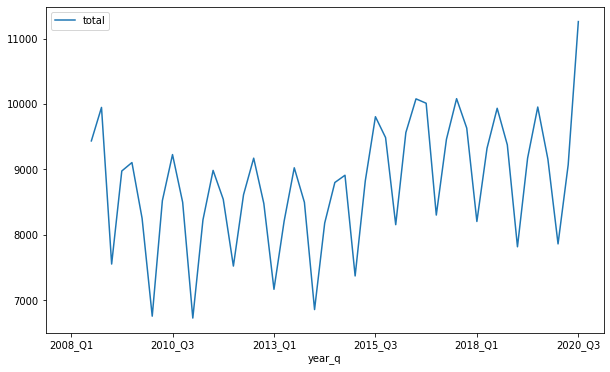

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
df.plot('year_q', "total", ax=ax)

We can notice there's some kind of repetition occuring. It seems as if every year the trend moves upward from Q1 to Q3 and trends back down from Q3, Q4, back to Q1. This suggests an annual cycle or seasonality to this variable. If I had to hypothesize why, I would guess that more cars are on the road in warmer months, hence more accidents.  
  
Its also useful to get an idea of the spread of our variable grouped by quarter. We can get a sense of how widely the fatalities count varies within each quarter. It seems as if the distribution is roughly the same normal distribution between quarters. The means are different, but the standard deviations are all relatively very close to one another. This is to be expected since we're looking at an aggregated number of events, just split up into bins of time.  

<AxesSubplot:xlabel='q', ylabel='total'>

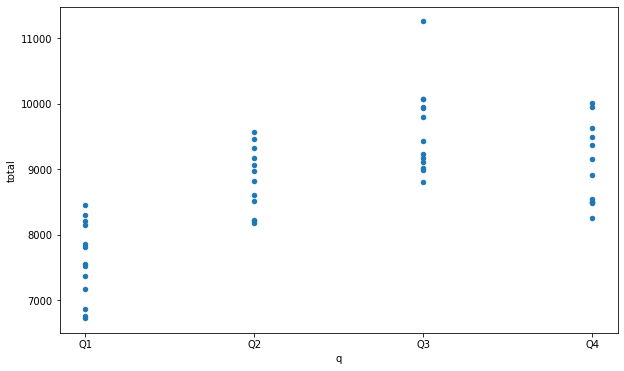

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
df.plot('q', "total", kind="scatter", ax=ax)

In [6]:
df.groupby("q").agg({"total": ["mean", "std"]})

total            
           mean         std
q                          
Q1  7595.307692  598.262398
Q2  8844.416667  494.359909
Q3  9604.153846  673.510807
Q4  9064.916667  619.769086

We can also get a sense of quarterly trends over every year by plotting each quarterly progression per year.

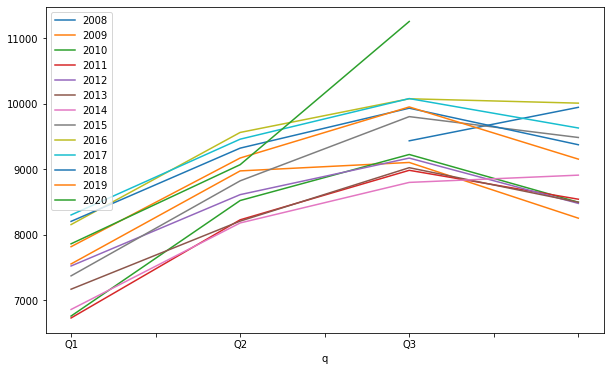

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))
for year in df['year'].unique():
    ydf = df[df['year'] == year]
    ydf.plot('q', 'total', kind='line', ax=ax, label=year)

# Imputing a Missing Value using Linear Regression

We can see below that 2008 is a broken line. In fact, it can be seen that there is a NaN value for the 2008 Q2 row. Since we're interested in doing some time-series forecasting, we should probably impute this value so we don't have missing values in our time steps. One approach to imputing this value would be to just take the average of all the other Q2 values and use that- which would give us 8844. Another strategy would be to take the halfway point between the value for 2008 Q1 and the value for 2008 Q3: (8495 + 9435) / 2 = 8947. Both of these are probably acceptable, but we might be able to leverage the quarterly trend we see every year in our inference. If we had an imputed point that really looked convicing, it might have that same angle of increase from Q1 to Q2, and the less steep increase from Q2 to Q3. If we were to just take the Q2 mean, it might not have any relationship with its Q1 and Q3 neighbors, and if we just took the mean of 2008 Q1 and Q3, it would give us a straight line for that timespan, which doesn't look like a reasonable trend to expect from this data. We could probably get the behavior we are looking for from a linear regression. Essentially, we would find the best coefficients to a linear equation that produce a dependent variable Q2 given the independent variables Q1, Q3, and year. [3]

In [83]:
# pivot our dataset so quarters become variables themselves
pvdf = df.pivot_table(index='year', columns=['q'], values=['total'])
pvdf.columns = pvdf.columns.droplevel(0)
pvdf.reset_index(inplace=True)
X = pvdf[pvdf['year'] != 2008]
# holdout - we will be imputing this value
X_holdout = pvdf[pvdf['year'] == 2008][['year', 'Q1', 'Q3']]

# train test split
# we want to evaluate how well our model works so we can train it 
# on a subset, and evaluate it on another. We'll leave the year
# of interest- 2008- as a hold out.
X_train = pvdf.sample(int(len(pvdf)*0.8))
y_train = X_train['Q2']
X_train = X_train[['year', 'Q1', 'Q3']]
X_test = pvdf[~pvdf.index.isin(X_train.index)]
y_test = X_test['Q2']
X_test = X_test[['year', 'Q1', 'Q3']]

In [84]:
# For this regression, we only have 13 rows: one for each year.
# So we don't need to do any incremental optimization, we can just
# plug all of our values into the normal equation.

# All this does is find the transformation (beta) that produces the best
# fit, or the least error solution to the equation. X dot beta -> Y
def normal_equation(X, Y):
    beta = np.dot((np.linalg.inv(np.dot(X.T,X))), np.dot(X.T,Y))
    return beta

def predict(X_test, beta):
    return np.dot(X_test, beta)

In [85]:
beta = normal_equation(X_train, y_train)
pred = predict(X_test, beta)

In [86]:
def metrics(pred, Y_test):

    # mean absolute error
    mae = np.mean(np.abs(pred-Y_test))

    # root mean square error
    mse = np.square(np.subtract(Y_test,pred)).mean() 
    rmse = np.sqrt(mse)

    # r-squared
    rss = np.sum(np.square((Y_test-pred)))
    mean = np.mean(Y_test)
    sst = np.sum(np.square(Y_test-mean))
    r2 = 1 - (rss/sst)
    
    return (np.round(m, 4) for m in [mae, rmse, r2])

mae, rmse, r2 = metrics(pred, y_test)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)
print("R squared: ", r2)

Mean Absolute Error:  144.6644
Root Mean Square Error:  170.152
R squared:  0.7297


The mean absolute error and the root mean square error look pretty good. The model on average was off by an absolute value of 144 fatalities, which is small relative to the problem. The rmse is on the same order of magnitude as well.
  
The R-squared score however is not great, and if we were to rerun this train/test again, we would see that the R-squared score is highly variable. This is because the dataset is so small, so the few outlier years can throw off the scores wildly, depending if they are in the test set or not. Since the R-squared score is a comparison of the models prediction for y (test set Q2) with the mean of y (mean of test set Q2). We're basically just measuring how much better the model predictions are than just using the mean as a guess for everything. Officially speaking, R-squared is the percentage of the variance of y explained by the model. But if thats too amorphous, it might be easier to look at the arithmetic.

In [26]:
# Running our actual imputation
y = X['Q2']
X = X[['year', 'Q1', 'Q3']]
beta = normal_equation(X, y)
pred = predict(X_holdout, beta)

In [27]:
pred

array([9514.37012875])

In [28]:
df.loc[df['year_q'] == '2008_Q2', 'total'] = pred[0]

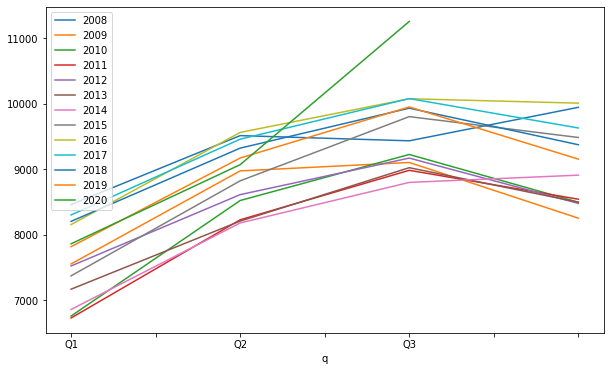

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
for year in df['year'].unique():
    ydf = df[df['year'] == year]
    # ydf = ydf[ydf['q'] != 'Q4']
    ydf.plot('q', 'total', kind='line', ax=ax, label=year)

Running our actual imputation, we get a value of 9514 for 2008 Q2. Plotting this back into our yearly line chart, we can see that it trends upward very similarly to all of the other Q1-to-Q2 lines. It does trend downward from Q2 to Q3, but it can be seen that at least one other year has that behavior (2009), which seems to suggest that maybe the best fit for the model was to favor the upward trend of Q1-to-Q2 over the slightly less upward trend of Q2-to-Q3.

# Time Series Forecasting with SARIMA
Earlier we plotted our data as a time series- starting from 2008 Q1 and ending at 2020 Q3. We noticed that the count of fatalities has a seasonal trend every year. If we wanted to forecast this behavior, in order to estimate the number of fatalities we should expect in the coming years, and maybe allocate resources accordinly, we may want to model the general trend from 2008-2020, along with the seasonal behavior that occurs every year. Since we can't achieve this non-linear seasonal behavior with a linear model- we can use a SARIMA (Seasonal Auto-Integrated Moving Average) model [1], which is part of the family of ARIMA models. A high level description of ARIMA is that it approximates a future timestep using the latest timestep $X_{t}$ and timesteps with a coefficient (a.k.a. lag operator) $X_{t} - {\alpha}_{1}*X_{t-1} - {\alpha}_{2}*X_{t-2} - ...$. Theres a lot more to it, but I won't go into massive detail here, but the wikipedia page is actually very good [2].

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [66]:
# train test split
split_ix = int(len(df)*0.8)
X = df.iloc[:split_ix]['total']
y = df.iloc[split_ix:]['total']

# fit model
model = SARIMAX(X, order=(1,0,1), seasonal_order=(1,0,1,4))
res = model.fit()
res.summary()

/home/dean/env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/dean/env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                   40
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 4)   Log Likelihood                -298.983
Date:                           Wed, 20 Oct 2021   AIC                            607.966
Time:                                   22:44:09   BIC                            616.410
Sample:                                        0   HQIC                           611.019
                                            - 40                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9542      0.103      9.224      0.000       0.751       1.157
ma.L1         -0.2605      0.225     -1.159      0.246      -0.701       0.180
ar.S.L4        0.9992      0.003    344.032      0.000       0.994       1.005
ma.S.L4       -0.8755      0.213     -4.116      0.000      -1.293      -0.459
sigma2      1.168e+05   2.42e-06   4.83e+10      0.000    1.17e+05    1.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                19.93
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -1.17
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.67e+25. Standard errors may be unstable.
"""

In [67]:
# predict test set
pred = res.forecast(steps=len(df)-split_ix)

In [68]:
pred

40    8110.404630
41    9399.039631
42    9971.013426
43    9629.012875
44    8083.476746
45    9372.082036
46    9944.527976
47    9603.653592
48    8060.119938
49    9348.532846
50    9921.295333
Name: predicted_mean, dtype: float64

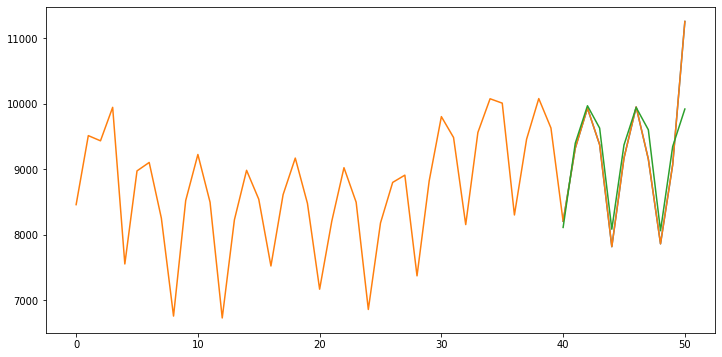

In [69]:
# Plot the predictions
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(df.iloc[split_ix:].index, y)
plt.plot(df.index, df.total)
plt.plot(df.iloc[split_ix:].index, pred)

In [70]:
# Evaluate model:
# Since we're basically just running a regression,
# we can use the same metrics from our linear model to evaluate performance
mae, rmse, r2 = metrics(pred, y)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)
print("R square: ", r2)

Mean Absolute Error:  291.0639
Root Mean Square Error:  457.5573
R square:  0.7724


/home/dean/env/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/home/dean/env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


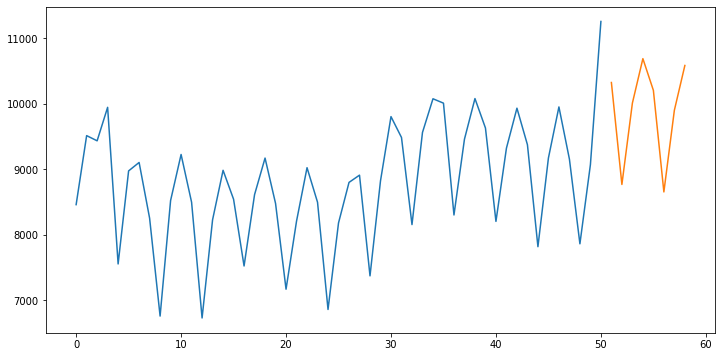

In [88]:
# Future forecasting:
# We can refit a SARIMA model to our entire dataset and predict future
# quarterly fatality totals.
X = df.total
model = SARIMAX(X, order=(1,0,1), seasonal_order=(1,0,1,4))
res = model.fit()
steps = 8
pred = res.forecast(steps=steps)
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(df.index, df.total)
plt.plot(list(range(len(df), len(df)+steps)), pred)

# Conclusion

Usually one would include confidence intervals when performing a regression like this, but I do think that its just out of scope for this initial discussion- but maybe worth bringing up in a follow up post!  
  
We can see that the SARIMA model does a good job reproducing the seasonality of the quarterly trend. It takes the general shape of the slowly increasing count- which is also seen in the training data (population size also increases slowly so that makes sense here).

# References

[1] https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/  
[2] https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average  
[3] http://mlwiki.org/index.php/Normal_Equation  
[4] https://data.bts.gov/Research-and-Statistics/Highway-Fatalities/nixb-9brz